# Practical Assignment: 3-SAT Problem 

3SAT, or the Boolean satisfiability problem, is a problem that asks what is the fastest algorithm to tell for a given formula in Boolean algebra (with unknown number of variables) whether it is satisfiable, that is, whether there is some combination of the (binary) values of the variables that will give 1.

## Our approach 
To solve this problem we considered the following formula:
$$ f(v1,v2,v3)= (¬v1 \lor ¬v2 \lor ¬v3)\land (¬v1 \lor v2 \lor v3) \land (v1 \lor ¬v2 \lor v3) \land (v1 \lor v2 \lor ¬v3) \land (v1\lor ¬v2\lor ¬v3) \land (v1\lor v2\lor v3) \land (¬v1\lor ¬v2\lor v3) $$

That can be modified to:
$$ f(v1, v2, v3) = ¬c1 \land ¬c2 \land ¬c3 \land ¬c4 \land ¬c5 \land ¬c6 \land ¬c7$$ where,
    $$ c1 = (v1 \land v2 \land v3)$$
    $$ c2 = (v1 \land ¬v2 \land ¬v3)  $$
    $$ c3 = (¬v1 \land v2 \land ¬v3)$$
    $$ c4 = (¬v1 \land ¬v2 \land v3)$$
    $$ c5 = (¬v1 \land v2 \land v3)$$
    $$ c6 = (¬v1 \land ¬v2 \land ¬v3)$$
    $$ c7 = (v1 \land v2 \land ¬v3)$$  
We decided to negate all clauses because it is easier to represent an ***AND Gate*** on the Quantum Circuit.


In [1]:
formula = [
    [True, True, True],
    [True, False, False],
    [False, True, False],
    [False, False, True],
    [False, True, True],
    [False, False, False],
    [True, True, False]
]


### Our formula has the following solutions for all possible boolean values

| v1 | v2 | v3 | ¬c1 | ¬c2 | ¬c3 | ¬c4 | ¬c5 | ¬c6 | ¬c7 | f |
|----|----|----|-----|-----|-----|-----|-----|-----|-----|----|
| 1  |  1  | 1 |  0  |  1  |  1  |  1  |  1  |  1  |  1  | 0 |
| 1  |  1  | 0 |  1  |  1  |  1  |  1  |  1  |  1  |  0  | 0 |
| 1  |  0  | 1 |  1  |  1  |  1  |  1  |  1  |  1  |  1  | 1 |
| 1  |  0  | 0 |  1  |  0  |  1  |  1  |  1  |  1  |  1  | 0 |
| 0  |  1  | 1 |  1  |  1  |  1  |  1  |  0  |  1  |  1  | 0 |
| 0  |  1  | 0 |  1  |  1  |  0  |  1  |  1  |  1  |  1  | 0 |
| 0  |  0  | 1 |  1  |  1  |  0  |  1  |  1  |  1  |  1  | 0 |
| 0  |  0  | 0 |  1  |  1  |  1  |  1  |  1  |  0  |  1  | 0 |



In [2]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, Aer, execute
from qiskit.tools.visualization import plot_histogram, plot_distribution
import matplotlib.pyplot as plt
import numpy as np

### Function execute_circuit(qc, shots=1024, decimal=False, reversed=False)
This function executes the quantum circuit that we implemented


In [3]:
def execute_circuit(qc, shots=1024, decimal=False, reversed=False):
    
    #define backend
    device = Aer.get_backend('qasm_simulator')
    #get counts
    counts = execute(qc, device, shots=shots).result().get_counts()
    
    if decimal:
        if reversed:
            counts = dict((int(a[::-1],2),b) for (a,b) in counts.items())
        else:
            counts = dict((int(a,2),b) for (a,b) in counts.items())
    else:
        if reversed:
            counts = dict((a[::-1],b) for (a,b) in counts.items())
        else:
            counts = dict((a,b) for (a,b) in counts.items())

    return counts

### Function initial_state(formula)
This function applies the Hadamard gate to the first 3 qubits turning them into a superposition state. Then it negates all the ancillas created for every formula, plus the last one which is the ancilla that we use to aggregate all results. 

In [4]:
def initial_state(formula):
    qr = QuantumRegister(3)
    ancilla = QuantumRegister(len(formula) + 1)
    cr = ClassicalRegister(3)
    qc = QuantumCircuit(qr, ancilla, cr)

    qc.h(qr)
    
    qc.x(ancilla)
    qc.h(ancilla)
    
    qc.barrier()
    
    return qc, qr, ancilla, cr

### Function oracle(qr, ancilla, formulas)
In this function we defined our **Oracle**.  
The parameter ***formula*** is a boolean matrix that represents the clauses of the formula that we are evaluating where each row is a clause.

In [5]:
def oracle(qr, ancilla, formula):
    qc = QuantumCircuit(qr, ancilla)
    
    for i, formula in enumerate(formula):
        for j in range(0, 3):
            if not formula[j]:
                qc.x(qr[j])
                
        qc.mcx(qr, ancilla[i])
        qc.x(ancilla[i])
        
        for j in range(0, 3):
            if not formula[j]:
                qc.x(qr[j])
        
        qc.barrier()
    # aggregate all results
    qc.mcx(ancilla[:-1],ancilla[-1])
    qc.barrier()
    return qc

### Function diffusion_operator(qr, ancilla)
In this function we defined our **Diffusor** that is used to amplify the probability of having the right solution.

In [6]:
def diffusion_operator(qr, ancilla):
    qc = QuantumCircuit(qr,ancilla)
    
    qc.h(qr)
    qc.x(qr)
    qc.ccz(qr[0], qr[1], qr[2])
    qc.x(qr)
    qc.h(qr)
    
    qc.barrier()
    return qc 

### Function grover(qc, qr, ancilla, oracle, formula)
In this function we apply the optimal number of **iterations**, composing the results of applying both oracle and diffusor.  
Note that our variable **M** has assigned the number of valid inputs.

$$ iterations = {\pi \over 4} \times \sqrt{N \over M} $$

In [7]:
def grover(qc, qr, ancilla, oracle, formula, M):
    elements = 2**3
    
    iterations = int(np.floor(np.pi/4 * np.sqrt(elements/M)))
    for j in range(iterations):
        qc = qc.compose(oracle(qr, ancilla, formula))
        qc = qc.compose(diffusion_operator(qr, ancilla))
    return qc

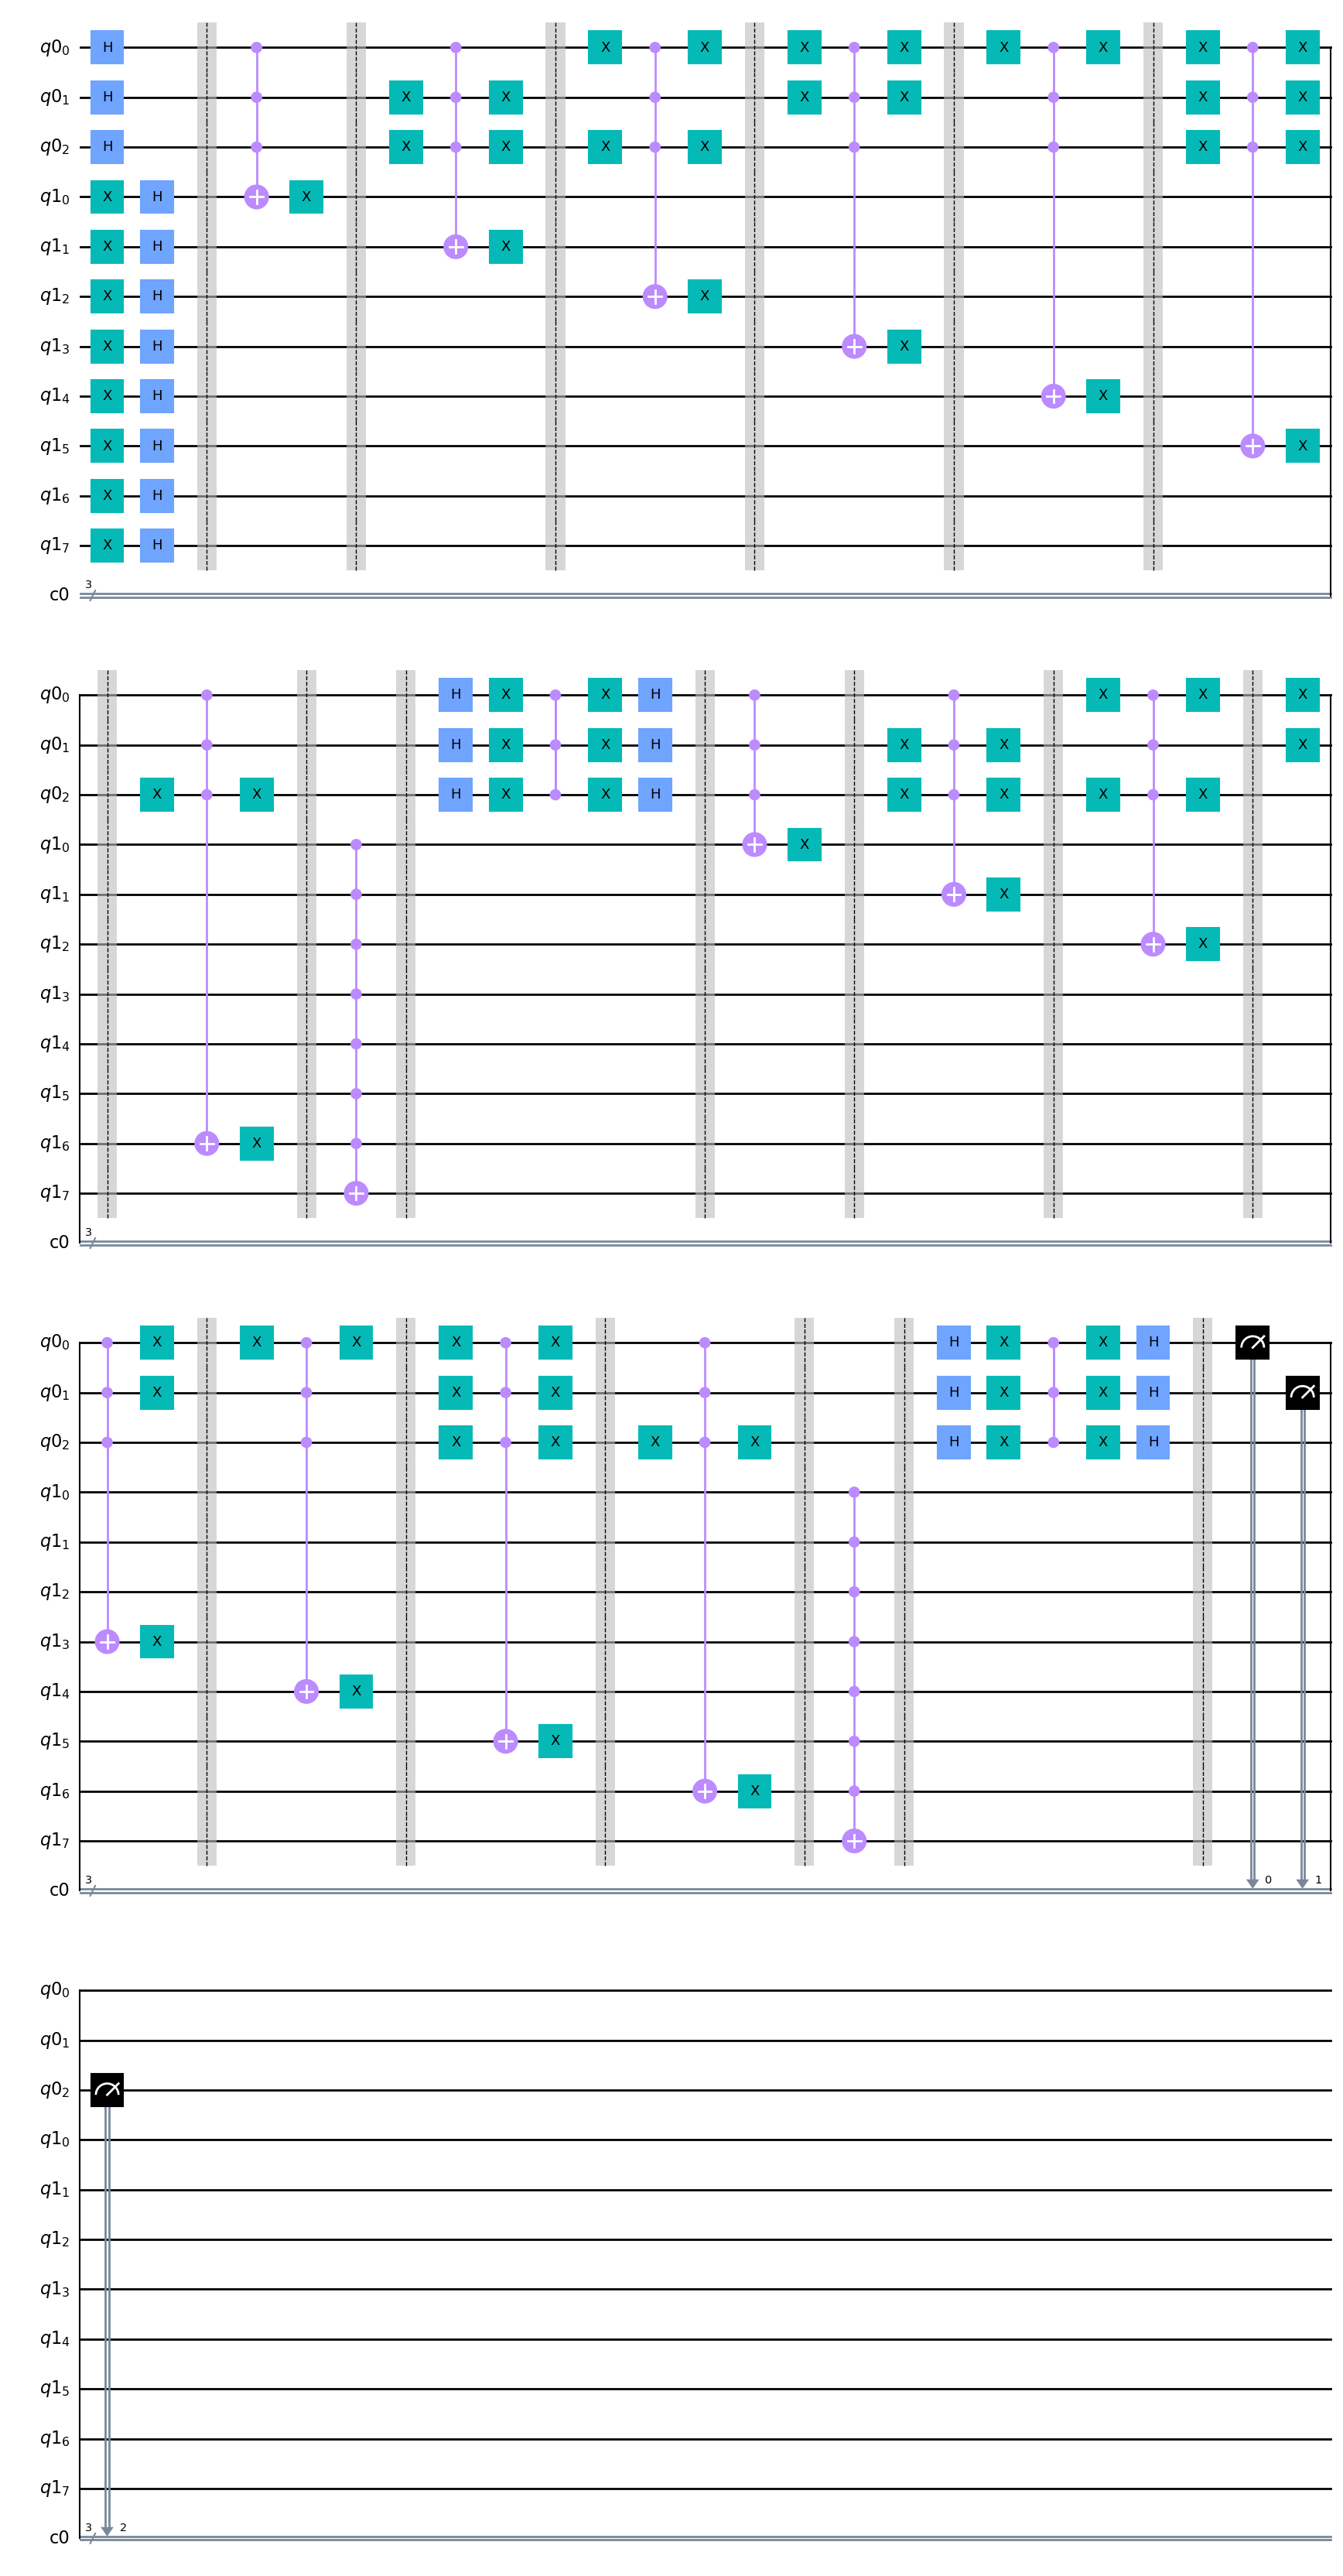

In [8]:
qc, qr, ancilla, cr = initial_state(formula)
# Nr of valid inputs
M = 1
qc = grover(qc, qr, ancilla, oracle, formula, M)
qc.measure(qr, cr)
qc.draw(output="mpl")

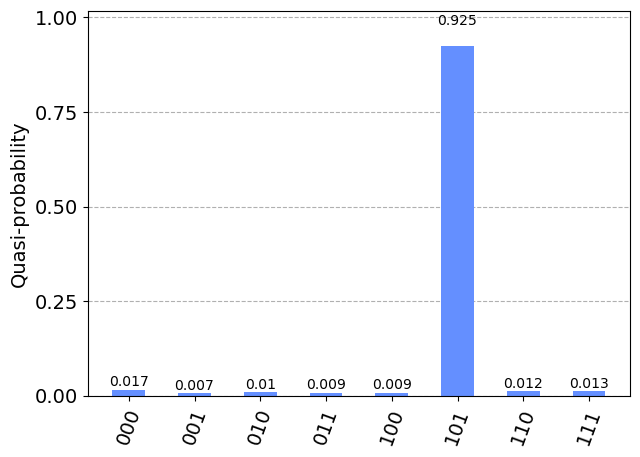

In [9]:
plot_distribution(execute_circuit(qc, 1024))

## Complexity

Using a classic algorithm the worst case would be $ 2^n $, where n is the number of qubits we are using to represent the input, so in this case would be $ 2^3 \equiv 8 $ iterations.  
Using Grover's Algorithm the worst case is $ \sqrt2^n $, so in this case would be $ \sqrt2^3 \equiv 2$ iterations.  

Comparing to a classical algorithm we can see that there's a quadratic speedup searching for the correct solution.